In [5]:
import argparse
import os
import numpy as np
from tqdm import tqdm

from mypath import Path
from dataloaders import make_data_loader
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator
from models.deeplab_xception import DeepLabv3_plus
from networks import deeplab_xception, deeplab_resnet

from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [3]:
# Load model
model = deeplab_resnet.DeepLabv3_plus(nInputChannels=3, n_classes=21, os=16, pretrained=True)
checkpoint = torch.load('run/pascal/deeplab-resnet/experiment_4/checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

Constructing DeepLabv3+ model...
Number of classes: 21
Output stride: 16
Number of Input Channels: 3


DeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
     

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize(513),
                     transforms.ToTensor(),
                     normalize])

In [13]:
def get_pascal_labels():
    return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128]])


In [14]:
def decode_segmap(label_mask):
    n_classes = 21
    label_colours = get_pascal_labels()

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


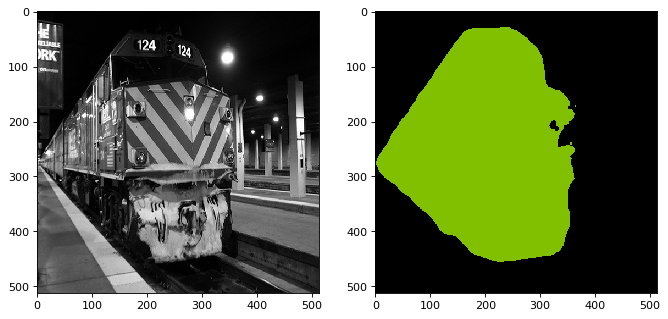

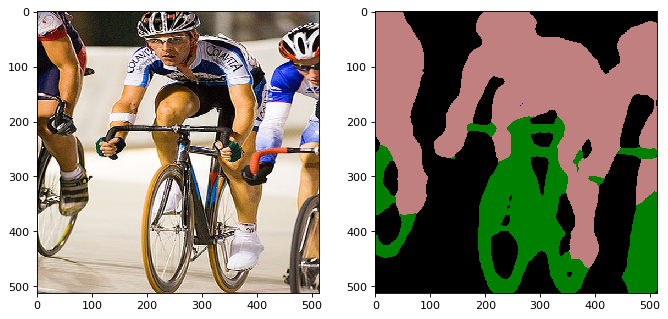

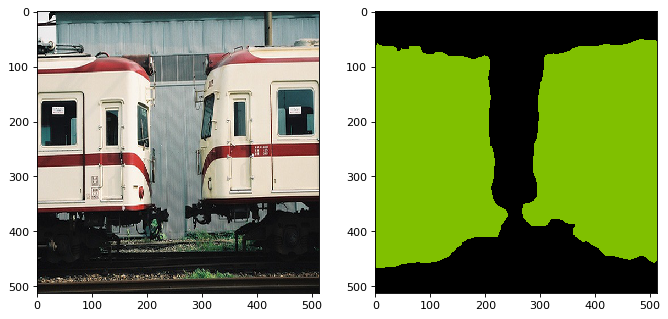

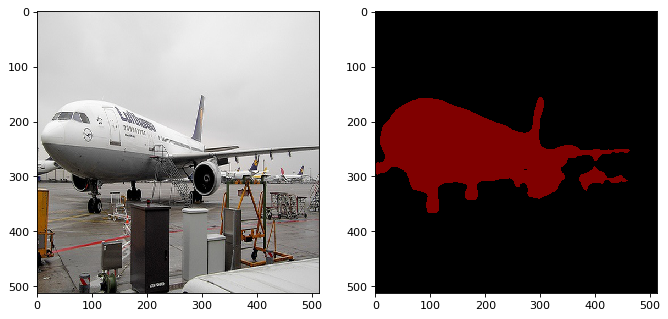

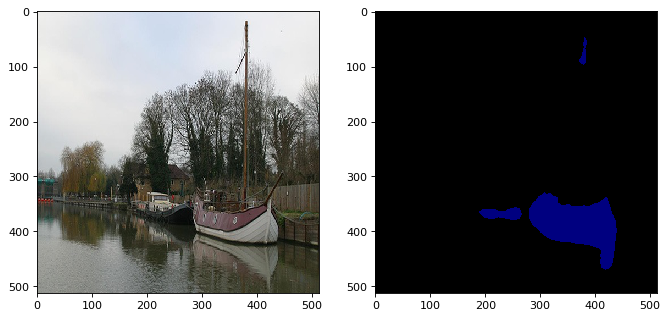

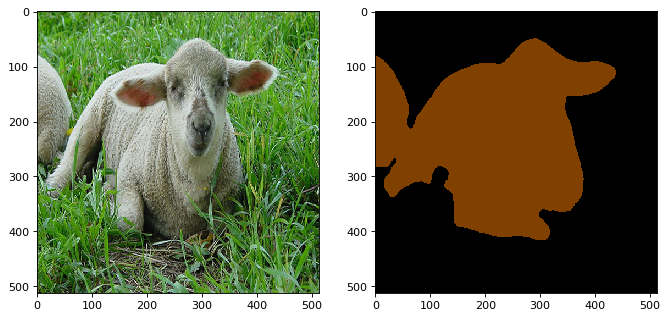

In [20]:
for img in os.listdir('data'):
    img_path = 'data/' + img
    im = Image.open(img_path).convert('RGB')
    im = im.resize((513, 513), Image.ANTIALIAS)
    img_tensor = preprocess(im)
    img_tensor.unsqueeze_(0)
    pred = model(torch.autograd.Variable(img_tensor.cuda()))
    _, tmp = pred.squeeze(0).max(0)
    pred_new = tmp.cpu().data.numpy()
    fig=plt.figure(figsize=(10, 10), dpi= 80)
    plt.subplot(1,2,1)
    plt.imshow(np.array(im))
    plt.subplot(1,2,2)
    segmap = decode_segmap(pred_new)
    plt.imshow(segmap)
    plt.show()
